# The Computational Image of the City: Landmarks

Four scores are here computed to extract computation landmarks: structural, visual, cultural, pragmatic.
The user has to provide at least an attribute shapefile containing the height attribute (the only mandatory field).
See below for further instructions on the data sources.

The user can also provide, seaprately, information about cultural/historical landmarks (e.g. position of listed important buildings); see *3 - Cultural component*

In [1]:
import pandas as pd, numpy as np, geopandas as gpd, osmnx as ox
from shapely.geometry import LineString
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

## Loading the layers

Provide a path referring to the building layer of the city/area of interest. This shouldn't be exactly your case-study area but a larger area (e.g. not Boston's city centre (case-study area), but the entire city of Boston).

Landmarks are extracted from buildings that are within the chosen case-study area (*buildings* geodataframe). Other buildings inside and around the case study area have to be included in the analysis in order to compute measures correctly, namely without "exalting" buildings located along the edges of the case-study area (*obstructions* geodataframe). *buildings* is a subset of *obstructions*.

You can:
* *Option1* - Load your *buildings* and *obstructions* gdfs from a local path --> **choose when: Files are ready and contains *height*, and a *land_use* field**


* *Option2* - Get a large set of building from OSM (*obstructions*) and extract the *buildings*, and attach information regarding height and land use from an existing file that it is in your possession (if this file is for example issued by an official data source and therefore more complete than OSM). This step makes sense only if you are not comfortable with the shapes of the buildings. Often these files contain indeed footprints too precise and not fitting the purposes of this work. OSM provides instead already more simplified footprints. --> **choose when: You have a shapefile with *height* and *land_use* attributes but you prefer to use the more simplified OSM geometries and attach the attributes to the OSM footprints**


* *Option3* - Load a buildings dataframe that would correspond to *obstructions* and obtain the *buildings* by using a certain distance or a case-study area polygon (see below for details).--> **choose when: You have a shapefile containing buildings in a large area, including and outside your case study area; you are comfortable with the geometries and the file *height* and *land_use* attributes are contained in such a file.**

Buildings smaller than 200 square meters are kept out of the analysis, as well as buildings whose height is lower than 1mt.

###  Do not forget to set the EPSG and CRS of your case-study area

In [2]:
city_name = 'Boston'
epsg = 26986 
crs = {'init': 'epsg:26986', 'no_defs': True}
input_path = 'Input/'+city_name+'/'
option = 3

In [3]:
# from local
case_study_area = gpd.read_file(input_path+city_name+'_city_center.shp').to_crs(epsg=epsg).iloc[0].geometry

### Option 1
Already prepared *buildings* and *obstructions* dataset.
Be aware that *buildings* should be a perfect subset of *obstructions*. This means that all the buildings in *buildings* should be in *obstructions*, sharing the same attributes.

* There should be a field named *base* and one *height*, representing the base height of the building (could be set to 0) and the height of the building.
* The *buildingID* should be already set correctly.

In [4]:
if option == 1:
    buildings = gpd.read_file(input_path+city_name+'_buildings.shp').to_crs(epsg=epsg)
    obstructions = gpd.read_file(input_path+city_name+'_obstructions.shp').to_crs(epsg=epsg)
    buildings.index, obstructions.index = buildings.buildingID, obstructions.buildingID
    buildings.index.name, obstructions.index.name = None, None
    obstructions['land_use_raw'] = obstructions['landUse'] #specify the land use field's name in the file
    obsutrctions.drop('landUse', axis = 1, inplace = True)

### Option 2
Here you download the obstructions from OSM using a large metropolotin area of your case-study are.
You also have the chance to attach attributes from a file in your possession and simplify touching footprints.
*buildings* is than obtained by using an OSM polygon representing the actual case-study area (and, in case, a buffer around it)

In [6]:
simplify = True
if option == 2:
    place = ''
    obstructions_na = ci.get_buildings_fromOSM(place, 'OSMplace', epsg = epsg, distance = None)
    obstructions_na = obstructions_na[obstructions_na.area > 1]

    ## simplify geometries?
    if simplify:
        obstructions_na = ci.simplify_footprints(obstructions_na, crs)
        obstructions_na['base'] = 0.0

    # attach attributes from..
    attribute_file = gpd.read_file(input_path+city_name+'_buildings_obstructions.shp').to_crs(epsg=epsg)

    # provide the name of the height, base_height, and land use attributes in your file
    obstructions = ci.attach_attributes(obstructions_na, attribute_file, 'height', base_field = None,  lan_use_field = 'landUse')
    
    # getting the polygon
    case_study_area = ox.geocode_to_gdf('Muenster Mitte').to_crs(epsg=epsg).iloc[0].geometry

    buildings = obstructions[obstructions.geometry.within(case_study_area)]
    buildings.index = buildings.buildingID
    buildings.index.name = None

### Option 3

If you don't have a precise case-study area polygon to pass:
Use the parameter *distance_from_center* to indicate till how far away from the center of the case-study area you want to include buildings. When the user doesn't provide the case-study area polygon nor the distance parameter, buildings and obstructions overlap; they have the same extent as the original input file.

*height_field* and *base_field* should indicate the maximum and the base height's fields of the buildings, in the original .shp file. When the second is not provided, the base height is automatically set to 0. 
*height_field* is necessary to perform the landmark extraction. If such a feature is not at disposal, set *height_field* to None.

In [7]:
if option == 3:
    buildings, obstructions = ci.get_buildings_fromSHP(input_path+city_name+'_obstructions.shp', epsg, 
                                                       case_study_area = case_study_area, distance_from_center = 0, 
                                                       height_field = 'height', base_field = 'base', land_use_field = 'landUse')

### Optional readjustments

In [8]:
obstructions['land_use_raw'].unique()

array(['residential', None, 'school', 'Exempt', 'Industrial', 'house',
       'Commercial', 'Apartments 4-6 Units', 'retail',
       'Apartments 7 Units above', 'Residential Condo Unit',
       'Mixed Use Res/Comm', 'train_station', 'Residential Three Family',
       'Residential Two Family', 'Commercial Land', 'commercial',
       'police', 'theatre', 'Commercial Condo Unit', 'restaurant',
       'Condominium Master', 'Condominium Parking', 'Exempt 121A',
       'Residential Single Family', 'courthouse', 'industrial', 'library',
       'apartments', 'storage_tank', 'fast_food', 'factory', 'church',
       'bank', 'place_of_worship', 'garage', 'university', 'office',
       'bicycle_parking', 'dormitory', 'parking', 'bar', 'warehouse',
       'education', 'cinema', 'government', 'terrace', 'boathouse',
       'hotel', 'service', 'construction', 'arts_centre', 'college',
       'roof', 'fuel', 'shelter', 'civic', 'clinic', 'hospital',
       'emergency_service', 'garages', 'Residential 

In [ ]:
lu_to_disregard = ['stockroom, warehouse', 'garage', 'stable', 'workshop','converter', ' pumping station', 'barracks', 'barn'
       'greenhouse', 'shed','greenhouse (botany)', 'bunker, shelter','heating plant', 'parking, garage', 
               'electricity substation']
obstructions = obstructions[~((obstructions.land_use_raw.isin(lu_to_disregard)) & (obstructions.area < 200))]

In [ ]:
obstructions = obstructions[~((obstructions.land_use_raw.isnull()) & (obstructions.height.isnull()))]
height = obstructions[~obstructions.height.isnull()].height.quantile(0.25)
obstructions['height'] = obstructions['height'].where(obstructions['height'] > 0.0, height)
buildings = buildings[buildings.buildingID.isin(obstructions.buildingID)]

## Visualisation

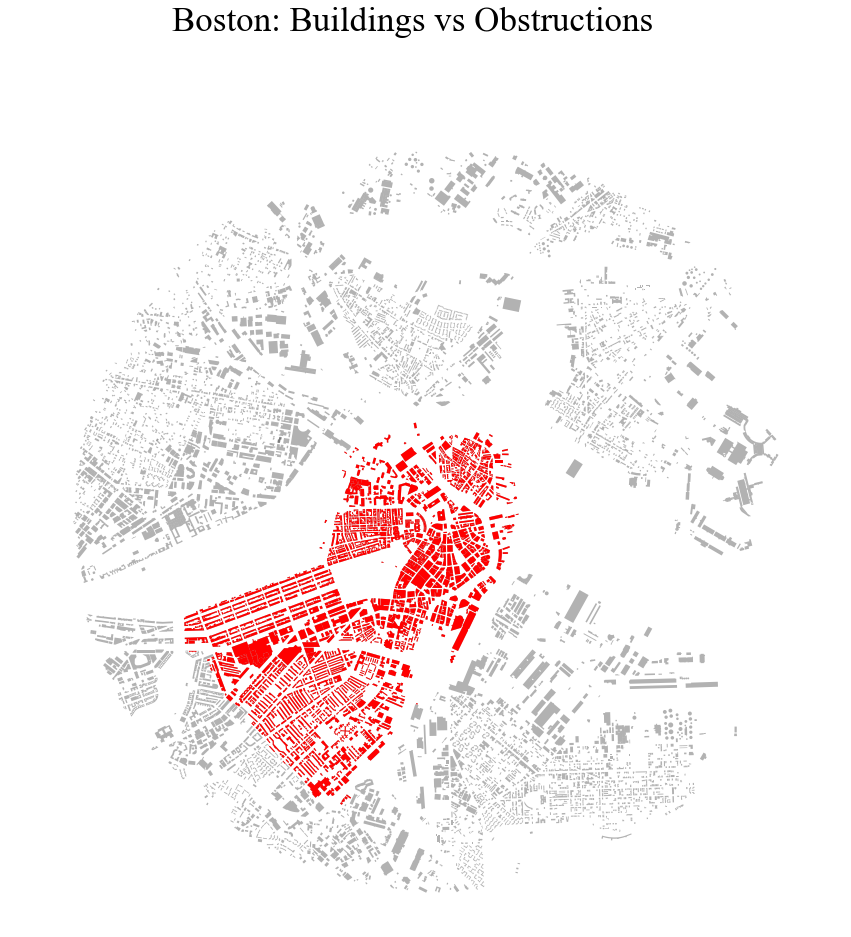

In [9]:
ci.plot_gdf(buildings, scheme = None,  black_background = False, fig_size = 15, title = city_name+': Buildings vs Obstructions',
             gdf_base_map = obstructions, base_map_color = 'black', base_map_alpha = 0.3)

## 1 - Structural component

It includes:
- distance from the road
- number of adjacent buildings 
- 2d advance visibility

In [12]:
# reading the street network and passing it in the function to compute the structural score
edges = gpd.read_file('Outputs/'+city_name+'/'+city_name+'_edges.shp')

# The 'buffer' parameter indicates distance within the algorithms look for neighbouring buildings
buildings = ci.structural_score(buildings, obstructions, edges, max_expansion_distance = 300, distance_along = 50, radius = 150)

In [3]:
nodes = gpd.read_file('Outputs/'+city_name+'/'+city_name+'_nodes.shp')

In [7]:
path = 'Outputs/'+city_name+'/'+city_name
sight_lines = gpd.read_file(path+'_sight_lines.shp').to_crs(epsg=epsg)

In [9]:
nodes

,x,y,nodeID,height,services,Bc_Rd,Bc_Rw,Sc,Rc400,Rc600,geometry
0,236576.775,901761.517,0,2,0,28453.000,15813.285,0.738,119,147,POINT (236576.775 901761.517)
1,235536.486,901067.607,1,2,0,11134.000,57272.445,0.740,44,101,POINT (235536.486 901067.607)
2,235751.468,903430.500,4,2,0,43722.000,66078.389,0.725,0,1,POINT (235751.468 903430.500)
3,236889.202,898252.992,7,2,0,18124.000,53791.805,0.760,2,5,POINT (236889.202 898252.992)
4,239085.731,903387.295,8,2,1,36510.000,45076.115,0.506,8,9,POINT (239085.731 903387.295)
...,...,...,...,...,...,...,...,...,...,...,...
2878,233370.375,901282.676,4446,2,0,157240.000,46202.654,0.818,31,50,POINT (233370.375 901282.676)
2879,236826.192,902983.499,4449,2,0,10.000,8715.940,0.620,0,0,POINT (236826.192 902983.499)
2880,238715.125,903007.750,4450,2,0,1057.000,24089.321,0.471,3,15,POINT (238715.125 903007.750)
2881,236496.855,901266.577,4452,2,6,9803.000,20165.457,0.776,75,254,POINT (236496.855 901266.577)


In [14]:
nodes[nodes.geometry.equals(point)]

KeyError: False

In [21]:
sight_lines.nodeID.unique()

array([None], dtype=object)

In [20]:
from shapely.geometry import Point
sight_lines['nodeID'] = None
for row in sight_lines.itertuples():
    index = row.Index
    coords = list(sight_lines.loc[index].geometry.coords)
    point = Point(coords[0])
    try:    
        nodeIDs = nodes[nodes.geometry.touches(point)].nodeID
    except:
        continue
    if len(nodeIDs > 0):
        sight_lines.at[index, 'nodeID'] = nodeID.iloc[0]

## 2 - Visual component

In [13]:
# saving a temporary file that will be used for constructing the sightlines
saving_path = 'Outputs/tmp/'+city_name+'/'+city_name
obstructions.to_file(filename = saving_path+'_obstructions.shp', driver='ESRI Shapefile')
buildings.to_file(filename = saving_path+'_buildings.shp', driver='ESRI Shapefile')

# leave the notebook and run the script sight_lines.py within ArcGis Pro (should work in ArcScene too)

In [10]:
# load sight_lines
path = 'Outputs/'+city_name+'/smallNetwork/'+city_name
sight_lines = gpd.read_file(path+'_sight_lines.shp').to_crs(epsg=epsg)

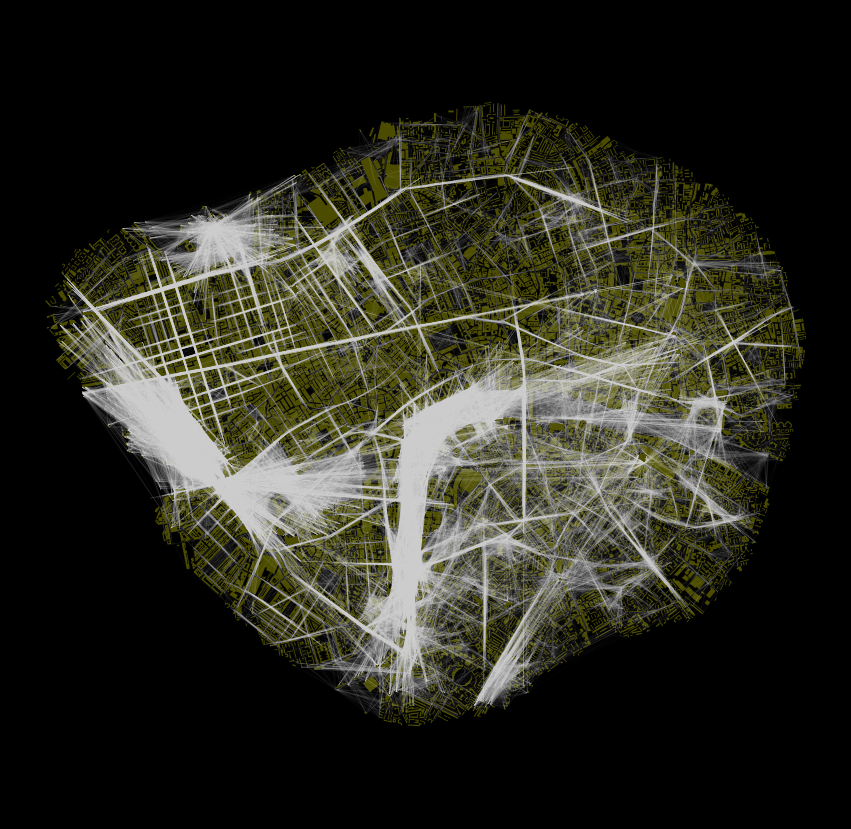

In [13]:
ci.plot_gdf(sight_lines, alpha = 0.02, color = 'white', gdf_base_map = buildings, base_map_color = 'yellow',
            base_map_alpha = 0.3)

### You can choose between two methods to compute the 3dvis score:

*combined* --> it computes a combined score that takes into account, per each building:
* the number of sight lines towards it;
* their average length
* the maximum lenght amongst them.

*longest* --> it just uses the longest sight line's length as a score

In [ ]:
# compute the visibility score
buildings, sight_lines = ci.visibility_score(buildings, sight_lines, 'longest')
buildings['3dvis'] = buildings['3dvis'].where(pd.notnull(buildings['3dvis']), 0.0)

## 3 - Cultural component

*Note: This part is case-study specific, see other examples for generalizable methods*

In [14]:
cultural_elements = gpd.read_file(input_path+'otherSources'+city_name+'_historic_buildings.shp').to_crs(epsg=epsg)
buildings = ci.cultural_score_from_dataset(buildings, cultural_elements)

## 4 - Pragmatic component

Before computing the pragmatic score, the *land_use_raw* raw field is categorised into more granular categories. You can fill in the following categories to accomodate descriptors not accounted for. Run the 1st and the 2nd cells below so to check which descriptors in *land_use_raw* are not inclued at the moment in the macro categories.

In [102]:
# introducing classifications and possible entries

adult_entertainment = ['brothel','casino', 'swingerclub', 'stripclub', 'nightclub', 'gambling'] 
    
agriculture = ['shed', 'silo', 'greenhouse', 'stable', 'agricultural and forestry',  'greenhouse (botany)',  
               'building in the botanical garden']

attractions = ['attractions',   'attraction','aquarium', 'monument',  'gatehouse', 'terrace', 'tower', 'attraction and leisure',
               'information', 'viewpoint', 'tourist information center', 'recreation and amusement park',  'zoo',
               'exhibition hall, trade hall', 'boathouse', 'bath house, thermal baths', 'entertainment hall', 'sauna']

business_services = ['bank', 'service','offices', 'foundation', 'office', 'atm', 'bureau_de_change', 'post_office', 
              'post_office;atm', 'coworking_space', 'conference_centre',  'trade and services', 'trade and services building',
                      'customs office', 'insurance', 'tax_office', 'post', 'administrative building',  'facility building',
                      'residential building with trade and services', 'data_center', 'tax office']

commercial = [ 'commercial',  'retail', 'pharmacy', 'commercial;educa', 'shop', 'supermarket', 'books', 'commercial services',
              'commercial land', 'car_wash', 'internet_cafe', 'driving_school', 'marketplace', 'fuel', 'car_sharing', 
              'commercial and industry buidling',  'crematorium', 'commercial building', 'commercial and industry building',  
              'commercial building to traffic facilities (general)', 'funeral parlor', 'gas station', 'car wash',
              'pumping station','boat_rental', 'boat_sharing',  'bicycle_rental', 'car_rental', 'dive_centre'] 

culture = ['club_house','gallery', 'arts_centre','cultural facility', 'cultural_centre', 'theatre', 'cinema', 'studio',
            'exhibition_centre', 'music_school', 'theater','castle', 'museum', 'culture']
    
eating_drinking = ['bbq', 'restaurant', 'fast_food', 'cafe', 'bar',  'pub', 'accommodation, eating and drinking', 
                   'ice_cream', 'kitchen', 'food_court', 'cafe;restaurant', 'biergarten']

education_research = ['university', 'research', 'university building', 'education and research', 'research_institute',
                     'research_institu']

emergency_service = [ 'fire brigade','fire_station','police', 'emergency service', 'resque_station', 'ranger_station',  
                     'security']

general_education = ['school', 'college', 'kindergarten', 'education', 'education and health', 'childcare',
             'language_school', 'children home',  'nursery',  'general education school']

hospitality = [ 'hotel',  'hostel', 'guest_house',  'building for accommodation',  'hotel, motel, pension',  'refuge']

industrial = ['industrial', 'factory', 'construction', 'manufacturing and production', 'gasometer', 'workshop', 
              'production building', 'manufacture']

medical_care = ['hospital', 'doctors', 'dentist','clinic','veterinary', 'medical care', 'nursing_home',  
                'sanatorium, nursing home', 'retirement home', 'healthcare', 'mortuary']

military_detainment = ['general aviation', 'barracks',  'military', 'penitentiary', 'prison']

other = ['toilets', 'picnic_site','hut', 'storage_tank', 'canopy','toilet',  'bunker, shelter',  'warehouse',  'converter',
         'garage', 'garages','parking', 'block', 'roof', 'no'] 

public = ['townhall', 'public_building',  'library','civic', 'courthouse', 'public', 'embassy',
          'public infrastructure', 'community_centre', 'court',  'district government', 
          'residential building with public facilities']

religious = ['church', 'place_of_worship','convent', 'rectory', 'chapel', 'religious building', 'monastery', 'nuns home',
              'vocational school',  'cathedral', 'religious buildings']
residential = [ 'apartments', None, 'NaN', 'residential','flats', 'houses', 'building', 'residential land', 
               'residential building', 'student dorm', 'building usage mixed with living', 'house']

social = ['social_facility', 'community_centre', 'community buidling', 'dormitory', 'social_centre', 'social serives building', 
         'social services',  'community hall',  'commercial social facility',  'recreational']

sport = ['stadium', 'sport and entertainment', 'sports or exercise facility', 'gym', 'sports building', 'sports hall', 
         'horse riding school',  'swimming pool',  'sport hall', 'bowling hall',  'indoor swimming pool', 'grandstand']

transport = ['transport', 'road transport', 'station', 'subway_entrance', 'bus_station', 'shipping facility building', 
             'train_station',  'railway building',  'railway station and london underground station', 'railway station',
            'london underground station', 'light rapid transit station', 'light rapid transit station and railway station']

utilities = ['gas supply', 'electricity supply', 'electricity substation', 'waste treatment building',
            'water supply', 'waste water treatment plant', 'smokestack', 'supply systems', 'waste management', 'water works',
              'heating plant', 'boiler house',  'telecommunication']

In [103]:
obstructions['land_use_raw'] = obstructions['land_use_raw'] .str.lower()
categories = [adult_entertainment, agriculture, attractions, business_services, commercial, culture, eating_drinking,
       education_research, emergency_service, general_education, hospitality, industrial, medical_care, military_detainment,
       other, public, religious, residential, social, sport, transport, utilities]
strings = ['adult_entertainment', 'agriculture', 'attractions', 'business_services', 'commercial', 'culture', 'eating_drinking',
       'education_research', 'emergency_service', 'general_education', 'hospitality', 'industrial', 'medical_care', 
           'military_detainment', 'other', 'public', 'religious', 'residential', 'social', 'sport', 'transport', 'utilities']

all_uses = [item for sublist in categories for item in sublist]
land_uses = list(obstructions.land_use_raw.unique())
to_categorise = [item for item in land_uses if item not in all_uses]

# shows existing raw categories to classify
to_categorise

[]

In [104]:
# and finally classify
obstructions = ci.classify_land_use(obstructions, 'land_use','land_use_raw', categories, strings)

### Pragmatic meaning computation

Computing the pragmatic score and assigning it to *buildings_gdf*.
The pragmatic component is computed on the *obstructions* GDF as the measure considers adjacent buildings' land use categories.
The *buffer* parameter indicates the extension of the area that is used to compute the score of a building, on the basis of
its land-use's frequency, in an area of 'buffer' meters around it.

In [110]:
obstructions = ci.pragmatic_score(obstructions, radius = 200)
buildings = pd.merge(buildings, obstructions[['prag', 'land_use', 'buildingID']], how = 'left', on = "buildingID")

In [88]:
buildings = gpd.read_file('Outputs/'+city_name+'/smallNetwork/'+city_name+'_landmarks.shp')

### URBAN DMA Categorisation
see https://journals.sagepub.com/doi/full/10.1177/0042098018819727

In [111]:
visit = ['adult_entertainment', 'attractions', 'culture', 'eating_drinking', 'sport', 'religious', 'social', 'sport']
work = ['agriculture', 'business_services', 'commercial', 'education_research', 'emergency_service', 'general_education',
        'industrial','medical_care', 'military_detainment','public', 'transport','utilities']
live = ['hospitality', 'residential'] 

categories = [visit, work, live]
strings = ['visit', 'work', 'live']
buildings = ci.classify_land_use(buildings, 'DMA','land_use', categories, strings)

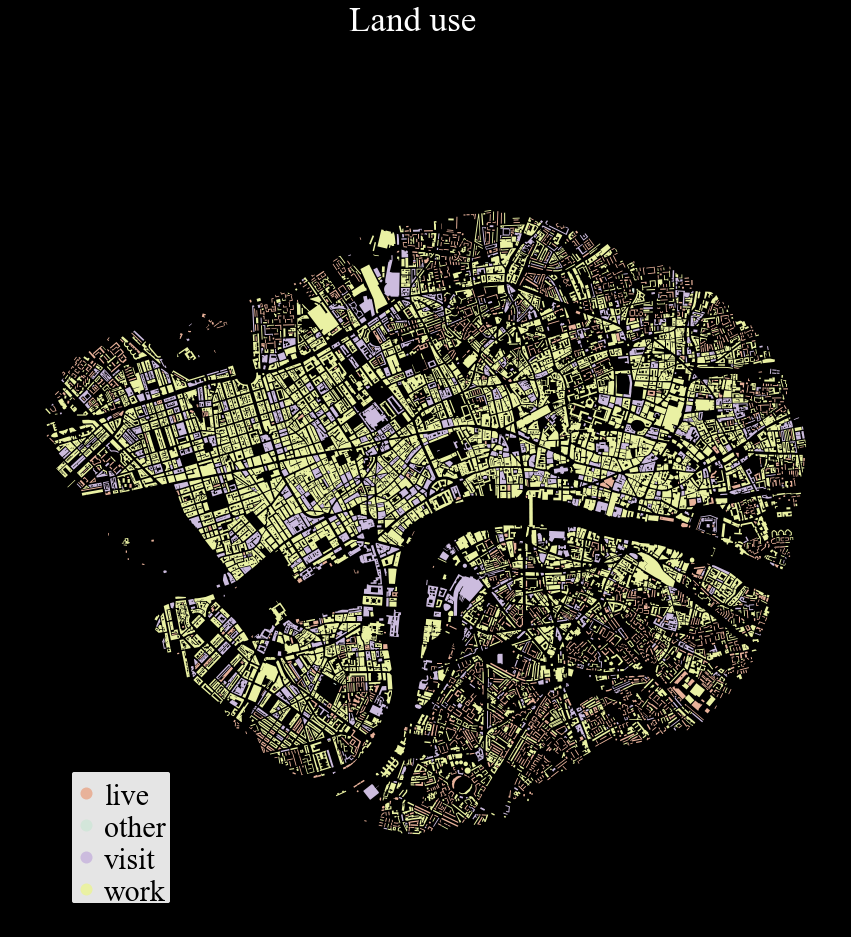

In [112]:
# visualising
ci.plot_gdf(buildings, column = 'DMA', title = 'Land use', black_background = True, fig_size = 15, legend = True)

# 5 - Final scores

In [52]:
# define weights

# global landmarkness components weights
g_cW = {'vScore': 0.50, 'sScore' : 0.30, 'cScore': 0.10, 'pScore': 0.10}
# global landmarkness indexes weights, cScore and pScore have only 1 index each
g_iW = {'vis': 0.50, 'fac': 0.30, 'height': 0.20, 'area': 0.30, 'a_vis':0.30, 'neigh': 0.20 , 'road': 0.20}

# local landmarkness components weights
l_cW = {'vScore': 0.25, 'sScore' : 0.35, 'cScore':0.10 , 'pScore': 0.30}
# local landmarkness indexes weights, cScore and pScore have only 1 index each
l_iW = {'vis': 0.50, 'fac': 0.30, 'height': 0.20, 'area': 0.30, 'a_vis': 0.30, 'neigh': 0.20 , 'road': 0.20}

In [ ]:
# Global and Local Score (1500 mt area)
# Global and Local Score (1000 mt area - but choose based on the extent of the case study area

buildings = ci.compute_global_scores(buildings, g_cW, g_iW)
buildings = ci.compute_local_scores(buildings, l_cW, l_iW, 1500)
buildings.crs = crs

## Visualisation

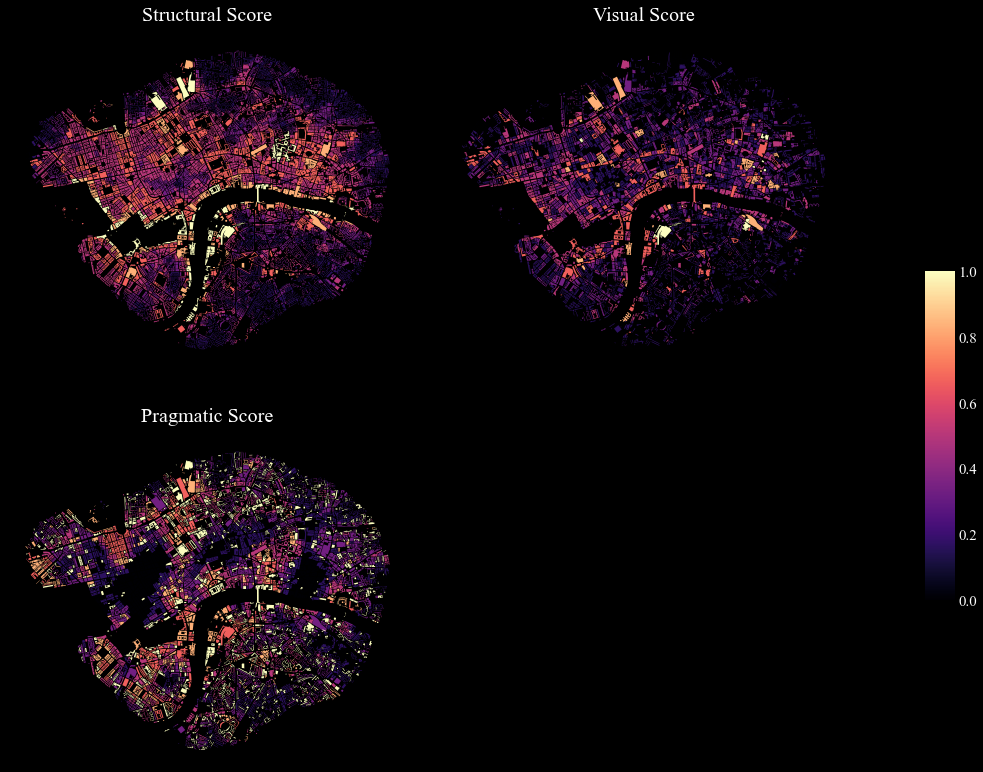

In [120]:
columns = ['sScore_sc', 'vScore_sc', 'pScore']
titles = ['Structural Score', 'Visual Score', 'Pragmatic Score']
fig = ci.plot_gdf_grid(gdf = buildings, columns = columns, titles = titles, black_background = True, fig_size = 15,
                  scheme = 'fisher_jenks', cmap = 'magma', cbar = True)

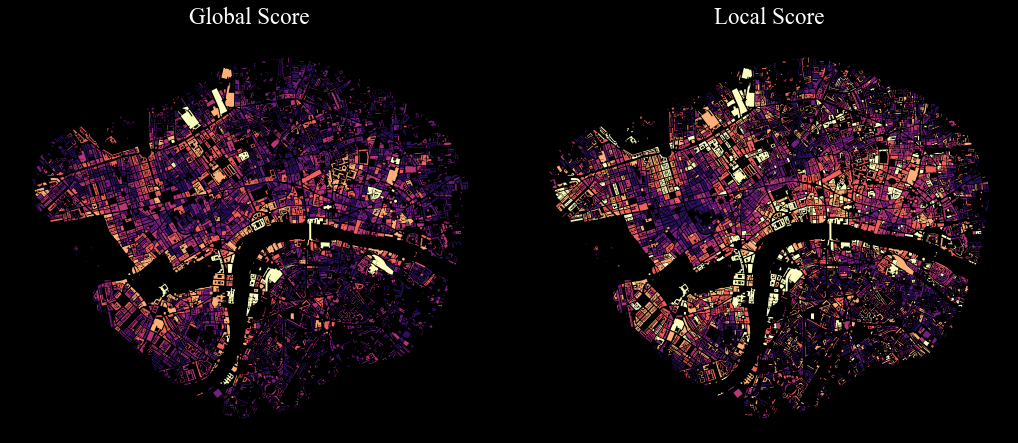

In [122]:
columns = ['gScore_sc', 'lScore_sc']
titles = ['Global Score', 'Local Score']
fig = ci.plot_gdf_grid(gdf = buildings, columns = columns, titles = titles, black_background = True, fig_size = 18,
                  scheme = 'fisher_jenks', cmap = 'magma', cbar = False)

In [58]:
saving_path = 'Outputs/'+city_name+'/smallNetwork/'+city_name
buildings.to_file(saving_path+'_landmarks.shp', driver='ESRI Shapefile')

# for GeoMason - ABM Pedestrian simulation (Polyline Z is not supported)
sight_lines2D = sight_lines.copy()
sight_lines2D['geometry'] = sight_lines2D.apply(lambda row: LineString([coor for coor in [row["geometry"].coords[i][0:2] for i in range(0, len(row["geometry"].coords))]]), axis = 1)
sight_lines.to_file(saving_path+'_sight_lines.shp', driver='ESRI Shapefile')
sight_lines2D.to_file(saving_path+'_sight_lines2D.shp', driver='ESRI Shapefile')

In [123]:
saving_path = 'Outputs/'+city_name+'/smallNetwork/'+city_name
buildings.to_file(saving_path+'_lan.shp', driver='ESRI Shapefile')